# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


# Membres du Groupe :

1. RANERIA Josia Mahatoky N°02
2. RAKOTOSAMIMANANA Andrivola Christian N°03
3. COIS NEWMAN Noah N°04
4. HASINAVALONA Lovatiana N°06
5. ANDRIAMAROAHINA Harimanantsoa N°07
6. RAKOTOARISOA Laingo Tsilavina N°10



# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

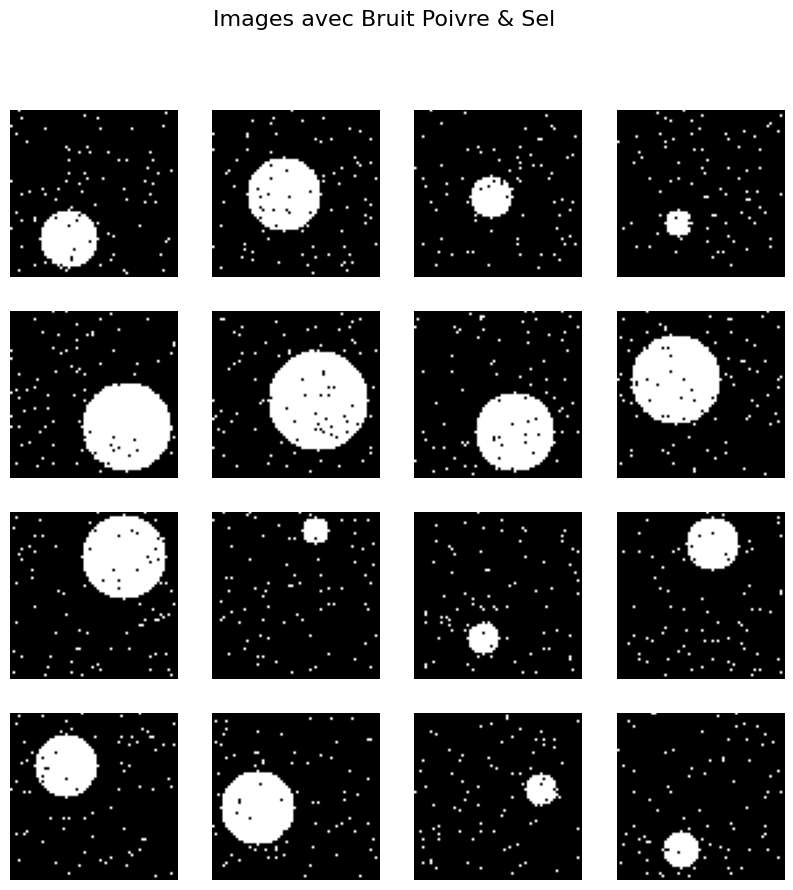

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    radius = np.random.randint(min_radius, max_radius)
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)
    cv2.circle(image, (x, y), radius, 255, -1)
    return image.astype('float32') / 255.0  # Normalisation entre 0 et 1

def add_salt_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    """Ajoute un bruit poivre et sel à l'image."""
    noisy_image = np.copy(image)
    total_pixels = image.shape[0] * image.shape[1]

    # Pixels blancs (sel)
    num_salt = int(total_pixels * salt_prob)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1]] = 1

    # Pixels noirs (poivre)
    num_pepper = int(total_pixels * pepper_prob)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1]] = 0

    return noisy_image

def generate_dataset(n_samples=10000, image_size=64, noise_type=None):
    """Génère un dataset d'images avec ou sans bruit."""
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)

        if noise_type == 'salt_pepper':
            img = add_salt_pepper_noise(img)

        data.append(img)

    data = np.array(data)
    data = np.expand_dims(data, axis=-1)  # Ajouter une dimension pour le canal (grayscale)
    return data

# Générer le dataset avec bruit poivre et sel
data_noisy = generate_dataset(n_samples=16, image_size=64, noise_type='salt_pepper')

# Afficher quelques exemples
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(data_noisy[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Images avec Bruit Poivre & Sel", fontsize=16)
plt.show()


## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [18]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_noisy, test_size=0.2, random_state=42)

print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)


Entraînement: (12, 64, 64, 1)
Test: (4, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [33]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)

autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_fc.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16384)               │       2,113,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_5 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 64, 64, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,286,212 (16.35 MB)

 Trainable params: 4,286,212 (16.35 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [34]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.6934 - val_loss: 0.6914
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6913 - val_loss: 0.6852
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.6849 - val_loss: 0.6656
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.6648 - val_loss: 0.6146
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.6124 - val_loss: 0.5189
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.5105 - val_loss: 0.4419
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.4034 - val_loss: 0.5773
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.4546 - val_loss: 0.5560
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.4297 - val_loss: 0.4567
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3649 - val_loss: 0.3997
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3420 - val_loss: 0.3899
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3525 - val_loss: 0.3908
Epo

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


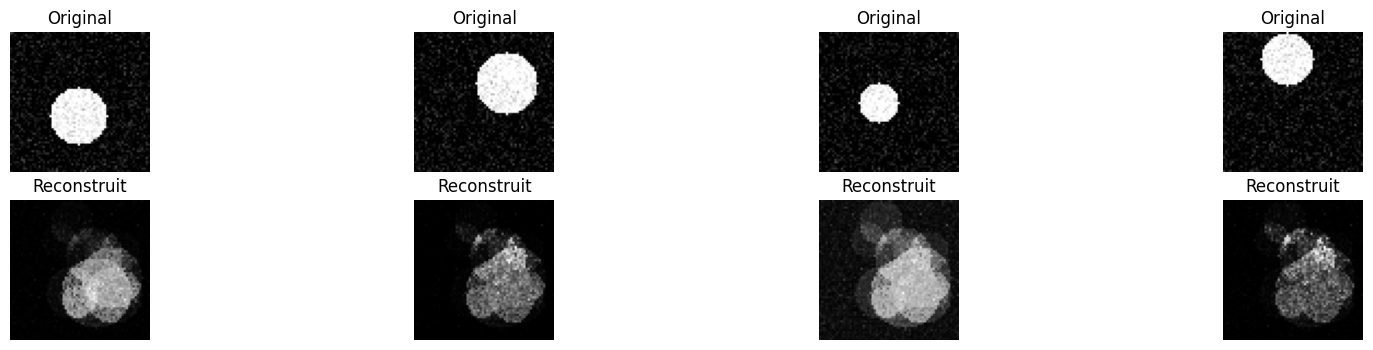

In [22]:
decoded_imgs_fc = autoencoder_fc.predict(test_data)

n = min(8, test_data.shape[0])  # Ajuster n si nécessaire

plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')

plt.show()


## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [40]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))

# ENCODER (Ajout de convolutions)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Aplatissement et passage vers l'espace latent
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

# DECODER (Ajout de convolution transpose pour reconstruction)
x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(16 * 16 * 64, activation='relu')(x)  # Correspond à la dernière couche avant Flatten
x = layers.Reshape((16, 16, 64))(x)

x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)  # Sigmoid pour normaliser [0,1]

# Création du modèle autoencodeur
autoencoder_conv = models.Model(input_img, decoded)
autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_conv.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16384)               │       2,113,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_17                  │ (None, 16, 16, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_18                  │ (None, 32, 32, 32)          │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (None, 64, 64, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,289,553 (16.36 MB)

 Trainable params: 4,289,553 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [41]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.6935 - val_loss: 0.6875
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.6875 - val_loss: 0.6550
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.6561 - val_loss: 0.5625
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.5648 - val_loss: 0.4439
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.4275 - val_loss: 0.5908
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4659 - val_loss: 0.5457
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.4226 - val_loss: 0.4387
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.3587 - val_loss: 0.3968
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3517 - val_loss: 0.3950
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3656 - val_loss: 0.3947
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3679 - val_loss: 0.3900
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3573 - val_loss: 0.3903
Ep

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step


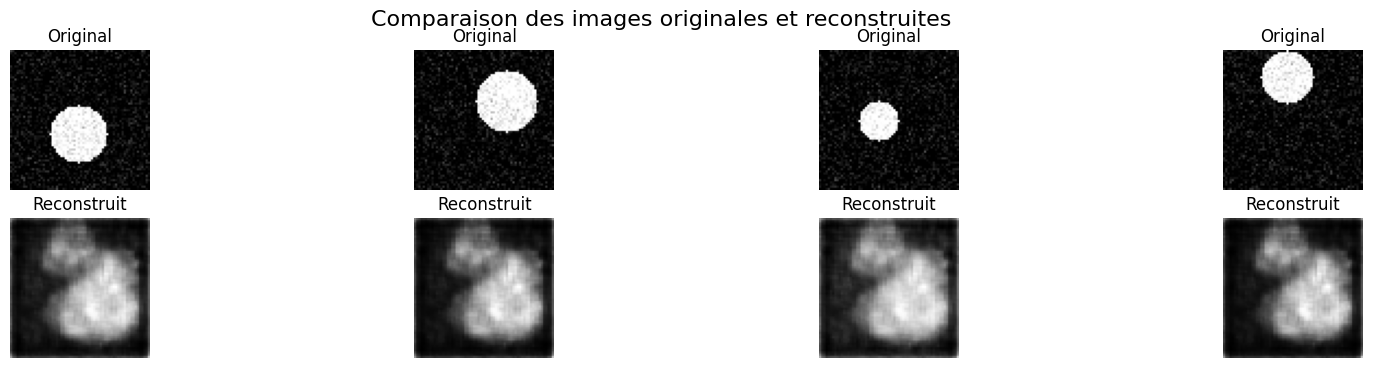

In [42]:
import matplotlib.pyplot as plt

# Prédire les images reconstruites
decoded_imgs_conv = autoencoder_conv.predict(test_data)

# Déterminer le nombre d'images à afficher (max 8)
n = min(8, test_data.shape[0])

plt.figure(figsize=(20, 4))
for i in range(n):
    # Image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')

plt.suptitle("Comparaison des images originales et reconstruites", fontsize=16)
plt.show()


## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.

#Réponse
1. Après avoir rendu l'image moins nette avec le bruitage poivre et sel, on a pu constater que les cercles reconstruits n'ont pas la forme désirés.
2. Nous avons décidé d'améliorer le modèle de l'autoencodeur convolutionnel
3.